In [1]:
import os
import glob

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# These lines of code are setting various parameters for the appearance of plots created using the matplotlib library. 
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size = 20)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['figure.figsize'] = (30.0, 8.0)
plt.rcParams['xtick.major.width']  = 1
plt.rcParams['ytick.major.width']  = 1
plt.rcParams['xtick.major.pad']= 8

In [3]:
tracer = 'LRG'
region = 'NScomb' # choices=['NGC', 'SGC', 'NS', 'S', 'NGCS', 'SGCS', 'NScomb']
theory_name = 'fs'
clustering_statistics = 'xi' # choices=['pk', 'xi']
on_the_fly_GaussianCovariance_matrix = '' # choices=['on_the_fly_GaussianCovariance_matrix', '']
zmin, zmax, b0 = {'LRG': (0.4, 1.1, 1.7), 'ELG': (1.1, 1.6, 0.84), 'QSO': (1.6, 2.1, 1.2)}[tracer]

In [4]:
base_dir = '/global/cfs/cdirs/desi/users/uendert/blinding/' # '/global/homes/u/uendert/desi-y1-kp45/blinding/' #'/global/cfs/cdirs/desi/users/uendert/blinding/' #'/global/homes/u/uendert/desi-y1-kp45/blinding' #'..'
profiles_fn = sorted(glob.glob(os.path.join(base_dir, 'blinded', 'test_w0-*','{}'.format(on_the_fly_GaussianCovariance_matrix), '{}'.format(theory_name), '{}'.format(clustering_statistics), 'profile_{}_{}_{}_{}.npy'.format(tracer, region, zmin, zmax))))
profiles_unblinded_fn = os.path.join(base_dir, 'unblinded','{}'.format(on_the_fly_GaussianCovariance_matrix), '{}'.format(theory_name), '{}'.format(clustering_statistics),'profile_{}_{}_{}_{}.npy'.format(tracer, region, zmin, zmax))

In [5]:
profiles_fn

['/global/cfs/cdirs/desi/users/uendert/blinding/blinded/test_w0-0.9040043101843285_wa0.025634205416364297/fs/xi/profile_LRG_NScomb_0.4_1.1.npy',
 '/global/cfs/cdirs/desi/users/uendert/blinding/blinded/test_w0-0.9057030601797708_wa-0.6831142329608426/fs/xi/profile_LRG_NScomb_0.4_1.1.npy',
 '/global/cfs/cdirs/desi/users/uendert/blinding/blinded/test_w0-0.970439944958287_wa-0.507777992481059/fs/xi/profile_LRG_NScomb_0.4_1.1.npy',
 '/global/cfs/cdirs/desi/users/uendert/blinding/blinded/test_w0-0.996229742129104_wa0.28930866494014884/fs/xi/profile_LRG_NScomb_0.4_1.1.npy',
 '/global/cfs/cdirs/desi/users/uendert/blinding/blinded/test_w0-1.0485430984101343_wa0.14015686872763022/fs/xi/profile_LRG_NScomb_0.4_1.1.npy',
 '/global/cfs/cdirs/desi/users/uendert/blinding/blinded/test_w0-1.106392086529483_wa0.45478607672455995/fs/xi/profile_LRG_NScomb_0.4_1.1.npy',
 '/global/cfs/cdirs/desi/users/uendert/blinding/blinded/test_w0-1.1616966626392298_wa0.3746115553255438/fs/xi/profile_LRG_NScomb_0.4_1.1.np

In [6]:
from desilike.samples import Profiles

In [7]:
bestfit = {name: [] for name in ['qpar', 'qper', 'dm', 'df', 'chi2min']}
error = {name: [] for name in ['qpar', 'qper', 'dm', 'df']}
expected = {name: [] for name in ['qpar', 'qper', 'dm', 'df']}
expected_unblinded = {}

from desilike.samples import Profiles
profiles_unblinded = Profiles.load(profiles_unblinded_fn)
index = profiles_unblinded.bestfit.logposterior.argmax()

bestfit_unblinded = {name: profiles_unblinded.bestfit[name][index] for name in error}
bestfit_unblinded['qiso'] = bestfit_unblinded['qpar']**(1./3.) * bestfit_unblinded['qper']**(2./3.)
bestfit_unblinded['chi2min'] = profiles_unblinded.bestfit.chi2min
# bestfit_unblinded['chi2min_red'] = float(profiles.bestfit.chi2min / profiles.bestfit.attrs['ndof'])
error_unblinded = {name: profiles_unblinded.error[name][index] for name in error}
for name in error_unblinded: error_unblinded[name] = error_unblinded[name]
                   
expected_unblinded['qpar'] = profiles_unblinded.attrs['expected']['qpar']
expected_unblinded['qper'] = profiles_unblinded.attrs['expected']['qper']
expected_unblinded['dm'] = profiles_unblinded.attrs['expected']['dm']
expected_unblinded['df'] = profiles_unblinded.attrs['expected']['df']

cov_unblinded = profiles_unblinded.covariance.view(params=['qper', 'qpar'])
jac = np.array([2.0 / 3.0, 1.0 / 3.0])
qiso_error_unblinded = {'qiso': jac.dot(cov_unblinded).dot(jac)**0.5}

qiso_error, qiso_error_fixed_covmat_unblinded = [], []

for profiles_fn_ in profiles_fn:
    profiles = Profiles.load(profiles_fn_)
    for name in expected: expected[name].append(profiles.attrs['expected'][name])
    index = profiles.bestfit.logposterior.argmax()
    for name in error: bestfit[name].append(profiles.bestfit[name][index])
    for name in error: error[name].append(profiles.error[name][index])
    cov = profiles.covariance.view(params=['qper', 'qpar'])
    jac = np.array([2.0 / 3.0, 1.0 / 3.0])
    qiso_error.append(jac.dot(cov).dot(jac)**0.5)    
    bestfit['chi2min'].append(float(profiles.bestfit.chi2min))

bestfit['qiso'] = list(np.array(bestfit['qpar'])**(1./3.) * np.array(bestfit['qper'])**(2./3.))
expected['qiso'] = list(np.array(expected['qpar'])**(1./3.) * np.array(expected['qper'])**(2./3.))
expected['dm'] = [0.] * len(expected['dm'])
error['qiso'] = qiso_error

error_unblinded['qiso'] = qiso_error_unblinded['qiso']

In [8]:
import pandas as pd

In [9]:
df_error_unblinded = pd.DataFrame(error_unblinded, index=[0])
df_error_unblinded.rename(columns={"qpar": "qpar_err", "qper": "qper_err", "dm": "dm_err", "df": "df_err", "qiso": "qiso_err"}, inplace=True)
df_error = pd.DataFrame(error)
df_error.rename(columns={"qpar": "qpar_err", "qper": "qper_err", "dm": "dm_err", "df": "df_err", "qiso": "qiso_err"}, inplace=True)

In [10]:
df_error_unblinded

,qpar_err,qper_err,dm_err,df_err,qiso_err
0,0.021749,0.013642,0.038864,0.068801,0.010539


In [11]:
df_error

,qpar_err,qper_err,dm_err,df_err,qiso_err
0,0.022142,0.013414,0.040223,0.069738,0.010998
1,0.022965,0.015006,0.038337,0.070119,0.011322
2,0.029712,0.014978,0.040629,0.068486,0.013485
3,0.021576,0.013040,0.039583,0.066417,0.010321
4,0.022911,0.016778,0.038017,0.070594,0.012139
5,0.022521,0.017208,0.038778,0.070988,0.012428
6,0.022938,0.010947,0.039280,0.060893,0.009437
7,0.023320,0.009951,0.038008,0.060838,0.009055


In [12]:
unblinded_cosmo = {'w0': -1.0, 'wa': 0.0, 'f': 0.8}
unblinded_cosmo.update(bestfit_unblinded)
unblinded_cosmo.update({'ndof': profiles_unblinded.bestfit.attrs['ndof']})
cosmo_unblinded = pd.DataFrame(unblinded_cosmo, index=[0])
cosmo_unblinded = pd.concat([cosmo_unblinded, df_error_unblinded], axis=1)
cosmo_unblinded

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.0,0.0,0.8,1.003164,0.988289,0.021549,0.927974,0.993222,62.714333,80,0.021749,0.013642,0.038864,0.068801,0.010539


In [13]:
base = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FirstGenMocks/AbacusSummit/Y1/mock1/LSScats/'
data_dir = base + 'blinded/jmena/test_w0-*/LSScats/blinded/'
fn_list = sorted(glob.glob(os.path.join(data_dir, 'blinded_parameters_{}.csv'.format(tracer))))

cosmo_blinded = {name: [] for name in ['w0', 'wa', 'f']}
ndof = {name: [] for name in ['ndof']}
for j, profiles_fn_ in zip(fn_list, profiles_fn):
    w0_blind, wa_blind, f_blind = np.loadtxt(j, delimiter=',', skiprows=1)
    cosmo_blinded['w0'].append(w0_blind)
    cosmo_blinded['wa'].append(wa_blind)
    cosmo_blinded['f'].append(f_blind)
    ndof['ndof'].append(profiles.bestfit.attrs['ndof'])

cosmo_blinded.update(bestfit)
cosmo_blinded.update(df_error)
cosmo_blinded.update(ndof)
cosmo_blinded = pd.DataFrame(cosmo_blinded)

blinded_concat = pd.concat([cosmo_unblinded, cosmo_blinded ], axis=0)

In [14]:
cosmo_unblinded

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.0,0.0,0.8,1.003164,0.988289,0.021549,0.927974,0.993222,62.714333,80,0.021749,0.013642,0.038864,0.068801,0.010539


In [15]:
blinded_concat

,w0,wa,f,qpar,qper,dm,df,qiso,chi2min,ndof,qpar_err,qper_err,dm_err,df_err,qiso_err
0,-1.000000,0.000000,0.800000,1.003164,0.988289,0.021549,0.927974,0.993222,62.714333,80,0.021749,0.013642,0.038864,0.068801,0.010539
0,-0.904004,0.025634,0.880000,1.025237,1.010630,0.013889,1.039632,1.015476,75.129379,80,0.022142,0.013414,0.040223,0.069738,0.010998
1,-0.905703,-0.683114,0.733309,0.993146,0.983762,0.018819,0.845765,0.986880,66.182387,80,0.022965,0.015006,0.038337,0.070119,0.011322
2,-0.970440,-0.507778,0.720000,0.978112,0.971164,0.027575,0.820750,0.973474,73.973423,80,0.029712,0.014978,0.040629,0.068486,0.013485
3,-0.996230,0.289309,0.880000,1.019066,0.998680,0.028849,1.021542,1.005430,63.168561,80,0.021576,0.013040,0.039583,0.066417,0.010321
4,-1.048543,0.140157,0.759545,1.002174,0.980820,0.017186,0.876392,0.987887,62.000822,80,0.022911,0.016778,0.038017,0.070594,0.012139
5,-1.106392,0.454786,0.764499,1.000603,0.980556,0.021732,0.892578,0.987193,69.550343,80,0.022521,0.017208,0.038778,0.070988,0.012428
6,-1.161697,0.374612,0.720000,0.987595,0.968896,0.014402,0.862743,0.975089,79.818522,80,0.022938,0.010947,0.039280,0.060893,0.009437
7,-1.233470,0.765853,0.720000,0.989539,0.966937,0.013477,0.839513,0.974413,73.739224,80,0.023320,0.009951,0.038008,0.060838,0.009055


In [16]:
df = pd.DataFrame(blinded_concat)
df = df[["w0", "wa", "f", "qpar", "qpar_err", "qper", "qper_err", "qiso", "qiso_err", "dm", "dm_err", "df", "df_err", "chi2min", "ndof"]]

print(df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:0.4f}".format, multirow = False))

\begin{tabular}{rrrrrrrrrrrrrrr}
\toprule
     w0 &      wa &      f &   qpar &  qpar\_err &   qper &  qper\_err &   qiso &  qiso\_err &     dm &  dm\_err &     df &  df\_err &  chi2min &  ndof \\
\midrule
-1.0000 &  0.0000 & 0.8000 & 1.0032 &    0.0217 & 0.9883 &    0.0136 & 0.9932 &    0.0105 & 0.0215 &  0.0389 & 0.9280 &  0.0688 &  62.7143 &    80 \\
-0.9040 &  0.0256 & 0.8800 & 1.0252 &    0.0221 & 1.0106 &    0.0134 & 1.0155 &    0.0110 & 0.0139 &  0.0402 & 1.0396 &  0.0697 &  75.1294 &    80 \\
-0.9057 & -0.6831 & 0.7333 & 0.9931 &    0.0230 & 0.9838 &    0.0150 & 0.9869 &    0.0113 & 0.0188 &  0.0383 & 0.8458 &  0.0701 &  66.1824 &    80 \\
-0.9704 & -0.5078 & 0.7200 & 0.9781 &    0.0297 & 0.9712 &    0.0150 & 0.9735 &    0.0135 & 0.0276 &  0.0406 & 0.8207 &  0.0685 &  73.9734 &    80 \\
-0.9962 &  0.2893 & 0.8800 & 1.0191 &    0.0216 & 0.9987 &    0.0130 & 1.0054 &    0.0103 & 0.0288 &  0.0396 & 1.0215 &  0.0664 &  63.1686 &    80 \\
-1.0485 &  0.1402 & 0.7595 & 1.0022 &    0.0

/tmp/ipykernel_140581/4214409729.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,


In [17]:
print(r'qiso_unblinded = {:.5} \pm {:.5}'.format(bestfit_unblinded['qiso'], qiso_error_unblinded['qiso'] ))

qiso_unblinded = 0.99322 \pm 0.010539


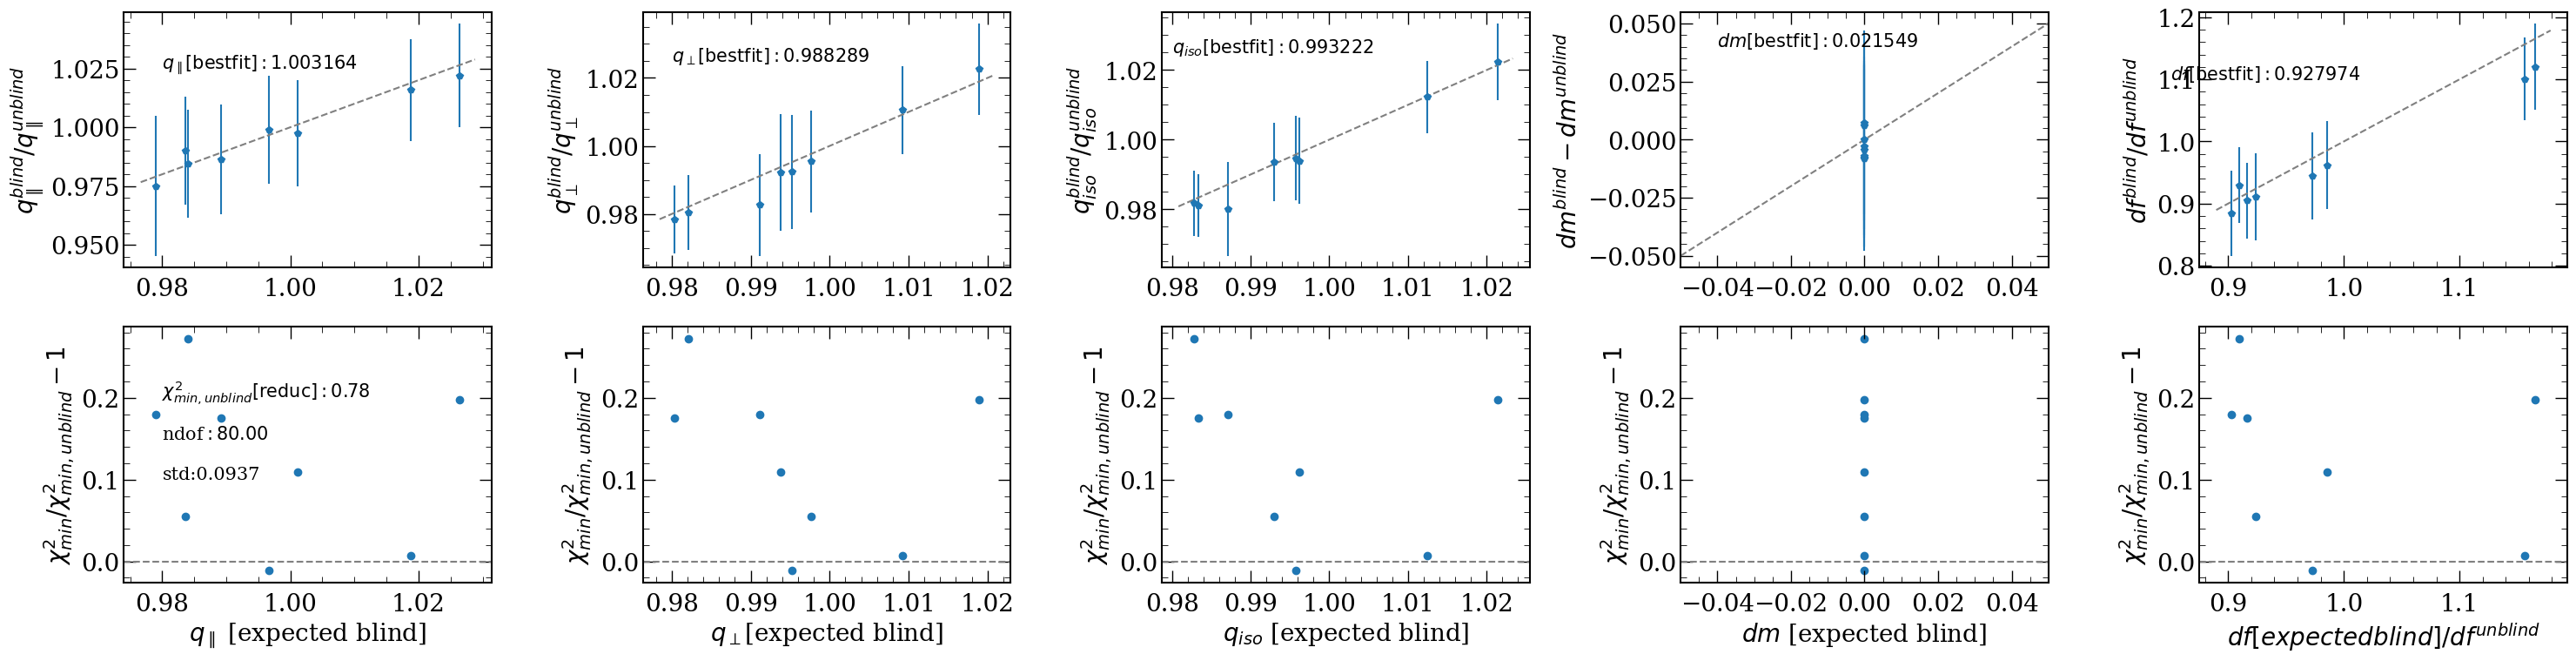

In [18]:
fig, ax = plt.subplots(2, 5, sharex='col')

ax[0, 0].errorbar(expected['qpar'], bestfit['qpar'] / bestfit_unblinded['qpar'], yerr=error['qpar'], fmt='p') #row=0, col=0
ax[0, 0].tick_params('x', labelbottom=True)
ax[0, 0].set(ylabel=r'$q_{\parallel}^{blind} / q_{\parallel}^{unblind}$')
ax[0, 0].plot(ax[0, 0].get_xlim(), ax[0, 0].get_xlim(), c='gray', linestyle='--')
ax[0, 0].text(0.98, 1.025, r'$q_{\parallel}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qpar']), fontsize=15)

ax[1, 0].scatter(expected['qpar'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 0].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{\parallel}$ [expected blind]')
ax[1, 0].axhline(y=0., color='gray', linestyle='--')
chi2min_red = profiles_unblinded.bestfit.chi2min / profiles_unblinded.bestfit.attrs['ndof']
if clustering_statistics == 'pk':
    ax[1, 0].text(0.98, 0., r'$\chi^2_{min, unblind}{\rm[reduc]}: %.2f$' % (chi2min_red), fontsize=15)
    chi2min_std = np.array(bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.).std()
    ax[1, 0].text(0.98, -0.04, r'std:{:.3}'.format(chi2min_std), fontsize=15)
    ax[1, 0].text(0.98, -0.02, r'ndof$: %.2f$' % (profiles_unblinded.bestfit.attrs['ndof']), fontsize=15)
else:
    ax[1, 0].text(0.98, 0.2, r'$\chi^2_{min, unblind}{\rm[reduc]}: %.2f$' % (chi2min_red), fontsize=15)
    chi2min_std = np.array(bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.).std()
    ax[1, 0].text(0.98, 0.1, r'std:{:.3}'.format(chi2min_std), fontsize=15)
    ax[1, 0].text(0.98, 0.15, r'ndof$: %.2f$' % (profiles_unblinded.bestfit.attrs['ndof']), fontsize=15)


ax[0, 1].errorbar(expected['qper'], bestfit['qper'] / bestfit_unblinded['qper'], yerr=error['qper'], fmt='p') #row=0, col=1
ax[0, 1].tick_params('x', labelbottom=True)
ax[0, 1].set( ylabel=r'$q_{\perp}^{blind} / q_{\perp}^{unblind}$')
ax[0, 1].plot(ax[0, 1].get_xlim(), ax[0, 1].get_xlim(), c='gray', linestyle='--')
ax[0, 1].text(0.98, 1.025, r'$q_{\perp}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qper']), fontsize=15)

ax[1, 1].scatter(expected['qper'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=1
ax[1, 1].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{\perp}$[expected blind]')
ax[1, 1].axhline(y=0., color='gray', linestyle='--')

ax[0, 2].errorbar(expected['qiso'], bestfit['qiso'] / bestfit_unblinded['qiso'], yerr=error['qiso'], fmt='p') #row=0, col=0
ax[0, 2].tick_params('x', labelbottom=True)
ax[0, 2].set(ylabel=r'$q_{iso}^{blind} / q_{iso}^{unblind}$')
ax[0, 2].plot(ax[0, 2].get_xlim(), ax[0, 2].get_xlim(), c='gray', linestyle='--')
ax[0, 2].text(0.98, 1.025, r'$q_{iso}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qiso']), fontsize=15)

ax[1, 2].scatter(expected['qiso'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 2].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{iso}$ [expected blind]')
ax[1, 2].axhline(y=0., color='gray', linestyle='--')

ax[0, 3].errorbar(expected['dm'], bestfit['dm'] - bestfit_unblinded['dm'], yerr=error['dm'], fmt='p') #row=0, col=0
ax[0, 3].tick_params('x', labelbottom=True)
ax[0, 3].set(ylabel=r'$dm^{blind} - dm^{unblind}$')
ax[0, 3].set_xlim(-0.05, 0.05)
ax[0, 3].plot(ax[0, 3].get_xlim(), ax[0, 3].get_xlim(), c='gray', linestyle='--')
ax[0, 3].text(-0.04, 0.04, r'$dm{\rm[bestfit]}: %f$' % (bestfit_unblinded['dm']), fontsize=15)

ax[1, 3].scatter(expected['dm'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 3].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$dm$ [expected blind]')
ax[1, 3].axhline(y=0., color='gray', linestyle='--')

ax[0, 4].errorbar(expected['df'] / bestfit_unblinded['df'], bestfit['df'] / bestfit_unblinded['df'], yerr=error['df'], fmt='p') #row=0, col=0
ax[0, 4].tick_params('x', labelbottom=True)
ax[0, 4].set(ylabel=r'$df^{blind} / df^{unblind}$')
ax[0, 4].plot(ax[0, 4].get_xlim(), ax[0, 4].get_xlim(), c='gray', linestyle='--')
ax[0, 4].text(0.85, 1.1, r'$df{\rm[bestfit]}: %f$' % (bestfit_unblinded['df']), fontsize=15)

ax[1, 4].scatter(expected['df'] / bestfit_unblinded['df'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 4].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$df [expected blind] / df^{unblind}$')
ax[1, 4].axhline(y=0., color='gray', linestyle='--')

# if clustering_statistics == 'pk':
#     fig.suptitle('Covariance generated individually for each blinded cosmology. {}_{}_{}_{}'.format(tracer, region, zmin, zmax), fontsize=18)
# else:
#     fig.suptitle('Same covariance generated with unblinded cosmology. {}_{}_{}_{}'.format(tracer, region, zmin, zmax), fontsize=18)

plt.tight_layout()
# plt.savefig(os.path.join(base_dir, 'blinded', '{}_one2one_plot_{}_{}_{}_{}.png'.format(clustering_statistics, tracer, region, zmin, zmax)))
plt.show()